In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
# engine = create_engine("sqlite:///Resources/hawaii.sqlite")
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)



In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# # Save references to each table
# measurements = Base.classes.measurements
# stations = Base.classes.station

# print(measurements.__table__)  # Prints details about the Measurement table
# print(stations.__table__)      # Prints details about the Station table

measurements = Base.classes.get("measurement")  # Try lowercase
stations = Base.classes.get("station")  # Ensure correct spelling

# If tables are found, print structure
if measurements and stations:
    print(measurements.__table__)
    print(stations.__table__)
else:
    print("Error: Could not find 'measurement' or 'station' tables!")


measurement
station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurements.date)).scalar()
print(f"Most recent date in the dataset: {most_recent_date}")



Most recent date in the dataset: 2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the date one year from the last date in data set.
twelve_months_ago = most_recent_date - pd.DateOffset(months=12)
twelve_months_ago = twelve_months_ago.date()
print(twelve_months_ago)

2016-08-23


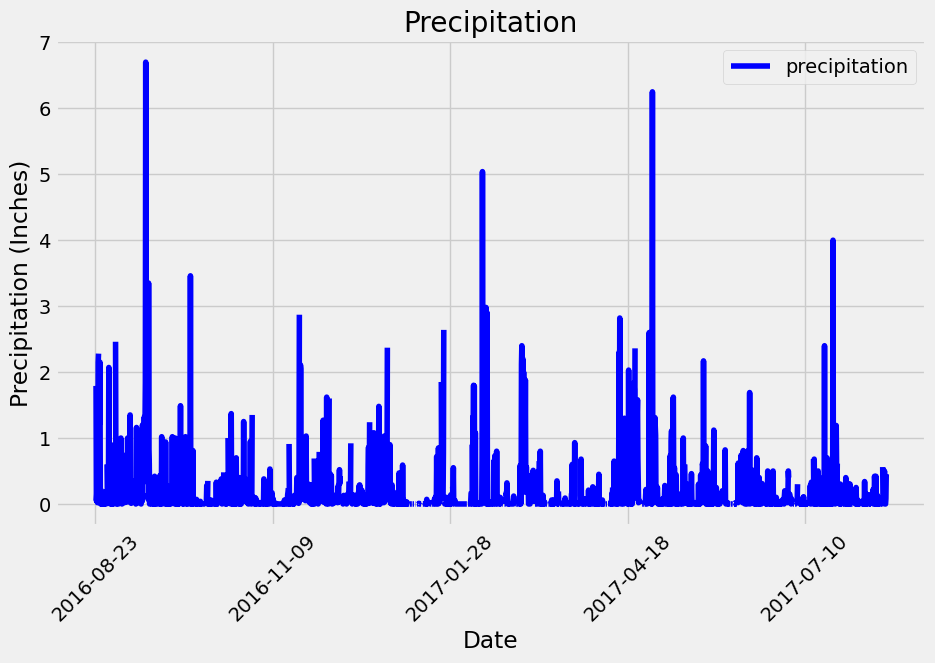

In [11]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurements.date, measurements.prcp).filter(measurements.date >= twelve_months_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_precip = pd.DataFrame(precip_data, columns=['date', 'precipitation'])
df_precip.head()

# Sort the dataframe by date
df_precip = df_precip.sort_values(by='date', ascending=True)
df_precip.head()
# Use Pandas Plotting with Matplotlib to plot the data

df_precip.plot(x='date', y='precipitation', kind="line", figsize=(10, 6), color='b')
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title("Precipitation")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary_stats=df_precip["precipitation"].describe()
precip_summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
# Query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(stations.station)).scalar()

# Display the result
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Query to find the most active stations (i.e., stations with the most rows)
most_active_stations = (
    session.query(measurements.station, func.count(measurements.station))
    .group_by(measurements.station)
    .order_by(func.count(measurements.station).desc())
    .all()
)

# Convert query results to a Pandas DataFrame
df_active_stations = pd.DataFrame(most_active_stations, columns=['station', 'count'])

# Display the results
df_active_stations

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [15]:
# Assuming most_active_stations is a list of tuples with station IDs and counts
# Extract the most active station ID
most_active_station_id = most_active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = (
    session.query(
        func.min(measurements.tobs),  # Lowest temperature
        func.max(measurements.tobs),  # Highest temperature
        func.avg(measurements.tobs)   # Average temperature
    )
    .filter(measurements.station == most_active_station_id)  # Filter by most active station ID
)

# Extract the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Display the results
print(f"Most Active Station: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")



Most Active Station: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


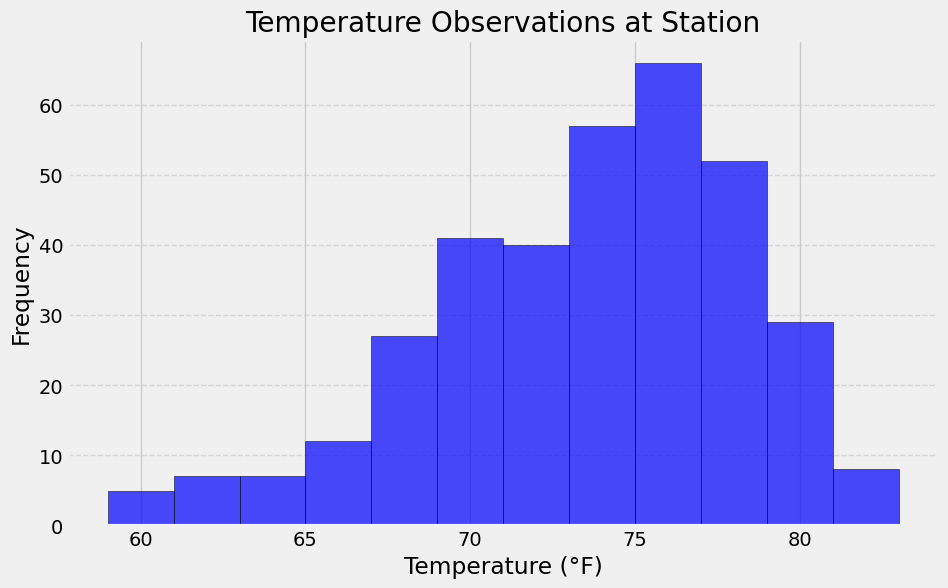

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = (
    session.query(measurements.station)
    .group_by(measurements.station)
    .order_by(func.count(measurements.station).desc())
    .first()
)

# Extract the station ID as a single string
most_active_station_id = most_active_station[0]

# Find the most recent date in the dataset
most_recent_date = session.query(func.max(measurements.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")

# Calculate the date 12 months ago
twelve_months_ago = most_recent_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temp_data = (
    session.query(measurements.tobs)
    .filter(measurements.station == most_active_station_id)
    .filter(measurements.date >= twelve_months_ago)
    .all()
)

# Convert query results to a Pandas DataFrame
df_temp = pd.DataFrame(temp_data, columns=['temperature'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(df_temp['temperature'], bins=12, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations at Station")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Close Session

In [17]:
# Close Session
session.close()